# **CELL 1 — Install & Imports (COLAB SAFE)**

In [1]:
# Cell 1: Install dependencies (Colab)
!pip install -q gymnasium[mujoco] stable-baselines3 matplotlib


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.0/42.0 kB 1.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 188.0/188.0 kB 13.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.0/7.0 MB 86.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 243.5/243.5 kB 20.5 MB/s eta 0:00:00


In [2]:
# Cell 1: Imports
import gymnasium as gym
import numpy as np
import os
import matplotlib.pyplot as plt

from stable_baselines3 import SAC
from stable_baselines3.common.monitor import Monitor
from stable_baselines3.common.results_plotter import load_results, ts2xy
from stable_baselines3.common.vec_env import DummyVecEnv


Gym has been unmaintained since 2022 and does not support NumPy 2.0 amongst other critical functionality.
Please upgrade to Gymnasium, the maintained drop-in replacement of Gym, or contact the authors of your software and request that they upgrade.
See the migration guide at https://gymnasium.farama.org/introduction/migration_guide/ for additional information.
/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


# **CELL 2 — Mount Google Drive**

In [16]:
# Cell 2: Mount Drive
from google.colab import drive
drive.mount("/content/drive")


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# **CELL 3 — Directory Setup**

In [18]:
# Cell 3: Paths
BASE_DIR = "/content/drive/MyDrive/DRL_Part2_Custom_MuJoCo"
MODEL_DIR = os.path.join(BASE_DIR, "models")
LOG_DIR   = os.path.join(BASE_DIR, "logs")

os.makedirs(MODEL_DIR, exist_ok=True)
os.makedirs(LOG_DIR, exist_ok=True)


# **CELL 4 — Custom MuJoCo Walker2D Environment (CORRECT)**

In [6]:
# Cell 4: Custom Environment

class CustomWalker2D(gym.Wrapper):
    """
    Custom MuJoCo Walker2D Environment
    Reward shaping only (physics unchanged)
    """

    def __init__(self):
        env = gym.make("Walker2d-v5")
        super().__init__(env)

        self.observation_space = env.observation_space
        self.action_space = env.action_space

    def reset(self, **kwargs):
        obs, info = self.env.reset(**kwargs)
        return obs, info

    def step(self, action):
        obs, _, terminated, truncated, info = self.env.step(action)

        # Standard Walker2D signals
        torso_height = obs[1]
        torso_angle  = obs[2]
        forward_vel  = obs[8]

        # ---------- STABLE REWARD SHAPING ----------
        forward_reward = 4.0 * forward_vel        # encourage motion
        alive_bonus    = 1.0                       # survival incentive
        control_cost   = 0.001 * np.sum(action**2)

        reward = forward_reward + alive_bonus - control_cost

        # ---------- SOFT TERMINATION ----------
        if torso_height < 0.8 or abs(torso_angle) > 1.2:
            terminated = True
            reward -= 5.0   # NOT catastrophic

        return obs, reward, terminated, truncated, info


# **CELL 5 — Environment Creation (IMPORTANT)**

In [7]:
# Cell 5: Environment wrapper

def make_env():
    env = CustomWalker2D()
    env = Monitor(env, LOG_DIR)
    return env

env = DummyVecEnv([make_env])


# **CELL 6 — Train SAC (STABLE SETTINGS)**

In [8]:
# Cell 6: Train SAC

model = SAC(
    "MlpPolicy",
    env,
    learning_rate=3e-4,
    buffer_size=1_000_000,
    batch_size=256,
    gamma=0.99,
    tau=0.005,
    ent_coef="auto",
    policy_kwargs=dict(net_arch=[256, 256]),
    verbose=1,
    device="cuda"   # GPU in Colab
)

print("🚀 Training SAC on Custom MuJoCo Walker2D...")
model.learn(total_timesteps=400_000)

model.save(os.path.join(MODEL_DIR, "sac_custom_walker2d"))
env.close()

print("✅ Training complete and model saved to Drive.")


Using cuda device
🚀 Training SAC on Custom MuJoCo Walker2D...
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 1        |
|    ep_rew_mean     | -5.02    |
| time/              |          |
|    episodes        | 4        |
|    fps             | 616      |
|    time_elapsed    | 0        |
|    total_timesteps | 4        |
---------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 1        |
|    ep_rew_mean     | -5.11    |
| time/              |          |
|    episodes        | 8        |
|    fps             | 678      |
|    time_elapsed    | 0        |
|    total_timesteps | 8        |
---------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 1        |
|    ep_rew_mean     | -5       |
| time/              |          |
|    episodes        | 12       |
|    fps             | 711      |
|    time_elapsed   

/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


Streaming output truncated to the last 5000 lines.
---------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 1        |
|    ep_rew_mean     | -2.85    |
| time/              |          |
|    episodes        | 398828   |
|    fps             | 71       |
|    time_elapsed    | 5558     |
|    total_timesteps | 398828   |
| train/             |          |
|    actor_loss      | 3.1      |
|    critic_loss     | 0.00132  |
|    ent_coef        | 0.0297   |
|    ent_coef_loss   | -0.0348  |
|    learning_rate   | 0.0003   |
|    n_updates       | 398727   |
---------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 1        |
|    ep_rew_mean     | -2.85    |
| time/              |          |
|    episodes        | 398832   |
|    fps             | 71       |
|    time_elapsed    | 5558     |
|    total_timesteps | 398832   |
| train/             |         

In [9]:
import pandas as pd
import matplotlib.pyplot as plt
import os


In [19]:
def plot_from_monitor(file_path, algo_name):
    df = pd.read_csv(file_path, skiprows=1)  # skip metadata row
    plt.figure(figsize=(9, 5))
    plt.plot(df["t"], df["r"])
    plt.xlabel("seconds since training start")
    plt.ylabel("Episode Reward")
    plt.title(f"{algo_name} on Walker2D")
    plt.grid()
    plt.show()


In [20]:
def plot_mean_reward_from_monitor(file_path, algo_name):
    df = pd.read_csv(file_path, skiprows=1)  # skip metadata row
    plt.figure(figsize=(9, 5))
    plt.plot(df["t"], df["r"].rolling(50).mean())
    plt.xlabel("seconds since training start")
    plt.ylabel("Episode Mean_Reward")
    plt.title(f"{algo_name} on Walker2D")
    plt.grid()
    plt.show()


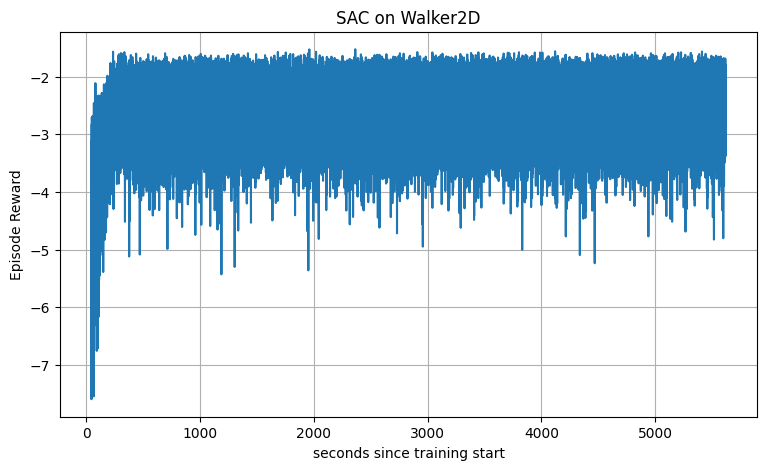

/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


In [25]:
plot_from_monitor(
    "/content/drive/MyDrive/DRL_Part2_Custom_MuJoCo/logs/monitor.csv",
    "SAC"
)


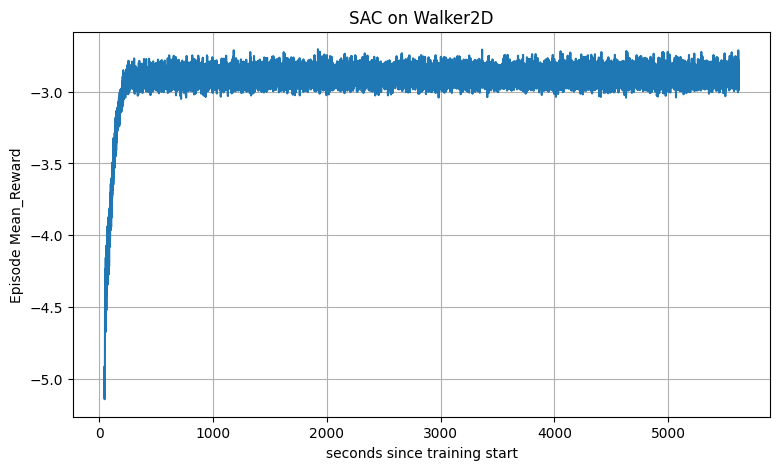

/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


In [27]:
plot_mean_reward_from_monitor(
    "/content/drive/MyDrive/DRL_Part2_Custom_MuJoCo/logs/monitor.csv",
    "SAC"
)
